# $l_1$--regularization
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to minimize:
$$
\min_x \frac 1 2 ||Ax-b||^2 + \lambda  ||x||_1 =: F(x)=f(Ax)+g(x),
$$
where $A\in \R^{m\times n}$ is a matrix data, $b\in \R^m$ is a given observation, and $x\in \R^n$ is an unknown signal.

We can rewrite the problem above in a primal-dual form as follows:
$$
\min_x \max_y g(x)+(Ax,y)-f^*(y),
$$
where $f(x) = \frac 1 2 ||x-b||^2$, $f^*(y) = \frac 1 2 ||y||^2 + (b,y) = \frac 1 2 ||y+b||^2 -\frac{1}{2}||b||^2$ and $g(x) = \lambda ||x||_1$.

For the problem in a primal-dual form we apply primal-dual methods.

In [ ]:
import matplotlib.pyplot as plt
from opt_operators import *
from methods.pd_algorithms import *
from methods.sp_pd_algorithms import *
import scipy.sparse.linalg as spr_LA
import numpy as np


We construct our data in one of the following ways below. We will use a fixed random generator for all our data to make experiments reproducible.

In [2]:
gen = 1

For the problem below we took $p = 0.5$ or $p = 0.9$

In [3]:
n = 500
m = 100
s = 10

la = 0.1
np.random.seed(gen)
B = np.random.normal(0, 1, (m,n))
p = 0.6
A = np.zeros((m,n))
A[0,:] = p*B[0,:]/(np.exp(1-p))
for i in np.arange(1,m):
    A[i,:] = p*A[i-1,:] + B[i,:]
        
np.random.seed(gen)
w = np.random.uniform(-5, 5, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)
    
np.random.seed(gen)
nu = np.random.normal(0, 0.1, m)
b = A.dot(w) + nu

Define $\nu$ and $b$

In [4]:
np.random.seed(gen)
nu = np.random.normal(0,0.1, m)
b = A.dot(w) + nu

Define all ingredients for primal-dual methods

In [5]:
def f_conj(y):
    return 0.5*(y+b).dot(y+b)

def g(x):
    return la*LA.norm(x,1)

def prox_g(x, rho):
    return prox_norm_1(x,la*rho)
    #return np.fmax(x, 0)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

def prox_f(y, rho):
    return (y + rho*b)/(1+rho)

# define energy 
def J(x,y,min_val):
    t = A.dot(x)-b
    return np.abs(0.5* t.dot(t) + la* LA.norm(x,1)-min_val)
# We need the following in order to apply accelerated primal-dual with f^* strongly convex.
def J1(y,x,min_val):
    return J(x,y,min_val)

def J2(x, Kx):
    grad = A.T.dot(Kx-b)
    aa = LA.norm(x - prox_g(x - grad, 1))/(1+LA.norm(x)+LA.norm(grad))  
    return aa
#### Computing distance

def dis_sub(la,x,y):
    y1 = y[x>0]; y2 = y[x<0]
    if y1.size > 0 and y2.size > 0: 
        a = np.hstack((y[x>0]+la, y[x<0] - la))
    elif y1.size > 0:
        a = y[x>0]+la
    else:
        a = y[x<0] - la
           
    z = y[x==0]; 
    if z.size>0:
        z1 =np.hstack((z[z<-la],z[z>la]))
        if z1.size>0:
            a = np.hstack((a,np.minimum(np.abs(z1-la),np.abs(z1+la))))
            
    #print(a)
    b = LA.norm(a,1)
    return b

Compute matrix norm of operator $A$. This may be long if you consider large-scale problems.

In [6]:
L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))
print(L**2)
# starting points
x0 = np.zeros(n)
y0 = -b

3764.245034916388


Get an approximation of the optimal value $F^*$

In [7]:
print("-----------------------------------------------")
print(str(m)+'--|--'+str(n)+'--|--'+str(s)+'--|--'+str(p))
print("L^2:", L**2)
# number of iterations
N = 300000
min_val = 0
    
beta = 1
if p == 0.6:
    kk=6
elif p == 0.9:
    kk=30
tau = kk / L
sigma = beta * tau
    
T_pd = 1e-8
    
ans0 = pd_sp_all(J, prox_g, prox_f_conj,dis_sub, A, x0, y0, sigma, tau, min_val,la,b, numb_iter=N, tol=T_pd)

t = A.dot(ans0[1])-b
min_val = 0.5* t.dot(t) + la* LA.norm(ans0[1],1)
print(min_val)
    
T = 1e-12
# SP-PDA
ans1 = pd_sp(J, prox_g, prox_f_conj, A, x0, y0, sigma, tau, min_val, numb_iter=N, tol=T)
    
# CP-PDA
tau = 1/L      
sigma = beta * tau 
ans2 = pd_new(J, prox_g, prox_f_conj, A,  x0, y0, sigma, tau, min_val, numb_iter=N, tol=T)

# CP-PDA-L
tau = np.sqrt(m)/L
ans3 = pd_linesearch_dual_is_square_norm(J, prox_g, -b, A,  x0, y0, tau, beta, min_val, numb_iter=N, tol=T)
print("-----------------------------------------------")







-----------------------------------------------
100--|--500--|--10--|--0.6
L^2: 3764.245034916388
----- SP PDA-----
Time execution: 0.64
iteration:
1533
error:
9.920192334256228e-09
2.419525602810566
----- SP PDA-----
Time execution: 0.74
iteration:
992
error:
9.867662242868391e-13
----- Primal-dual method -----
Time execution: 2.25
Iteration: 5439
9.99644811372491e-13
----- Primal-dual method with  linesearch. f^*(y)=0.5*||y-b||^2-----
Time execution: 1.2459559440612793
iteration:
2498
error:
9.907630271754897e-13
-----------------------------------------------


To see the plots of residual $f(Ax)+g(x) - f(Ax^*)-g(x^*)$. For simplicity, we just set $f(Ax^*)+g(x^*)$ as the smallest number among all energy values for all methods during all iterations. Alternatively, you can increase number of iterations to obtain even better ground truth solution.

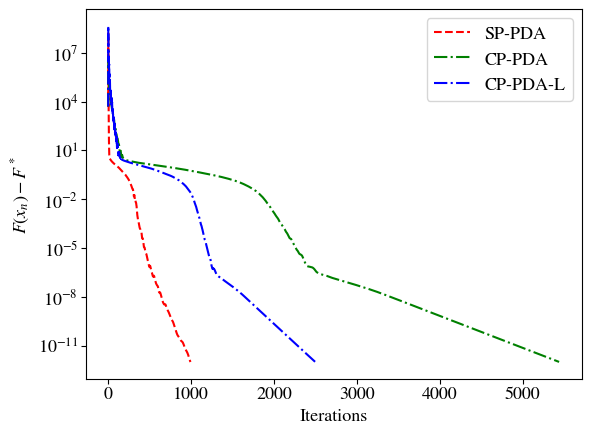

In [15]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1.5)
mpl.rcParams.update(
        {'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2
    
plt.plot(ans1[0], 'r--', label = 'SP-PDA')
plt.plot(ans2[0], 'g-.', label = 'CP-PDA')
plt.plot(ans3[1], 'b-.', label = 'CP-PDA-L')
    
plt.yscale('log')
plt.xlabel(u'Iterations')
plt.ylabel('$F(x_n)-F^*$')
# plt.ylim([1e-12,1e+13])
plt.legend()
plt.savefig('figures/'+str(m/100)+'-'+str(n/100)+'-'+str(p)+'-iter.pdf')
plt.show()

CPU Time:

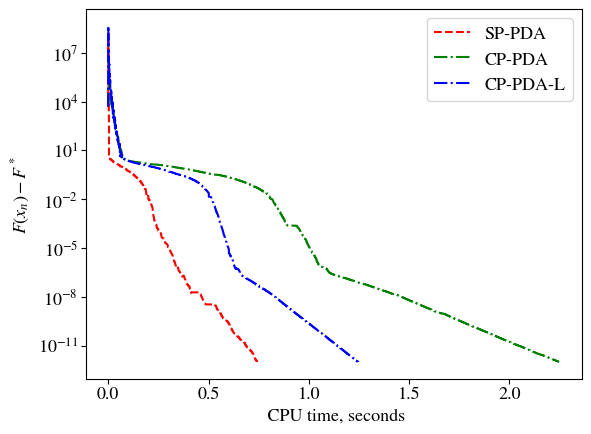

In [14]:
plt.plot(ans1[-1], ans1[0], 'r--', label = 'SP-PDA')
plt.plot(ans2[-1], ans2[0], 'g-.', label = 'CP-PDA')
plt.plot(ans3[0], ans3[1], 'b-.', label = 'CP-PDA-L')
plt.yscale('log')
plt.xlabel(u' CPU time, seconds')
plt.ylabel('$F(x_n)-F^*$')
# plt.ylim([1e-10,1e+13])
plt.legend()
plt.savefig('figures/'+str(m/100)+'-'+str(n/100)+'-'+str(p)+'-time.pdf')
plt.show()

----- SP PDA-----
Time execution: 2.47
iteration:
4265
error:
9.949736368142226e-09
1
----- SP PDA-----
Time execution: 0.87
iteration:
2310
error:
9.95386995050751e-09
2
----- SP PDA-----
Time execution: 0.6
iteration:
1744
error:
9.897182878804145e-09
3
----- SP PDA-----
Time execution: 0.36
iteration:
1543
error:
9.933348282809007e-09
4
----- SP PDA-----
Time execution: 0.34
iteration:
1500
error:
9.947629220352638e-09
5
----- SP PDA-----
Time execution: 0.71
iteration:
1473
error:
9.592698607674421e-09
6
----- SP PDA-----
Time execution: 0.94
iteration:
1477
error:
9.834622977100693e-09
7
----- SP PDA-----
Time execution: 0.91
iteration:
1469
error:
9.899659147993844e-09
8
----- SP PDA-----
Time execution: 0.83
iteration:
1499
error:
9.637476511281662e-09
9
----- SP PDA-----
Time execution: 0.7
iteration:
1607
error:
9.729624411702886e-09
10
----- SP PDA-----
Time execution: 0.6
iteration:
1607
error:
9.729624411702886e-09
11
----- SP PDA-----
Time execution: 0.64
iteration:
2548
e

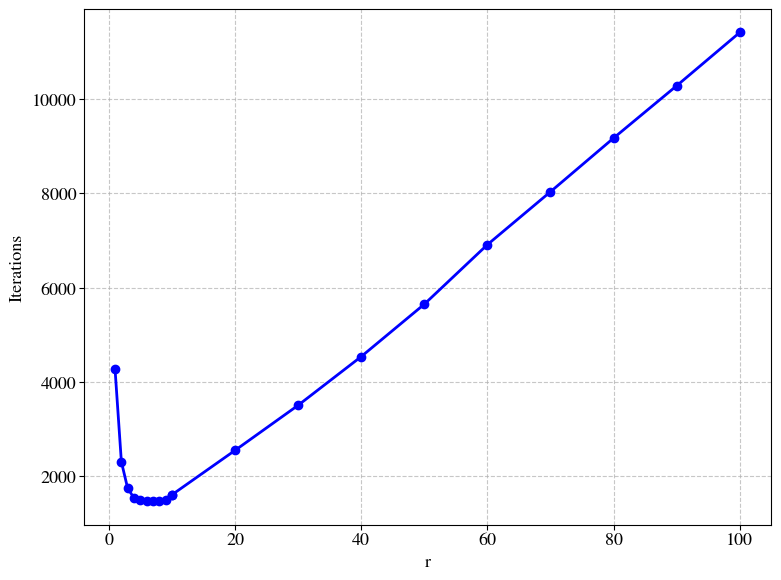

In [13]:
# 步长灵敏度测试

# number of iterations
N = 300000
min_val = 0
    
def test_parameter_sensitivity(kk_range, tol=1e-8, max_iter=300000):
    results = []
    x0 = np.zeros(n)
    y0 = -b
    
    min_iterations = float('inf')
    best_kk = None
    countt = 0
    
    for kk in kk_range:
        tau = kk / L
        sigma = tau  # 设置ratio=1
        
        start_time = time()
        ans = pd_sp_all(J, prox_g, prox_f_conj, dis_sub, A, x0, y0, sigma, tau, min_val, la, b,
                            numb_iter=max_iter, tol=tol)
        end_time = time()
        
        iterations = len(ans[0])
        if iterations < min_iterations:
            min_iterations = iterations
            best_kk = kk
        
        results.append({
            'kk': kk,
            'convergence': ans[0][-1],  # 最终收敛误差
            'iterations': iterations,   # 迭代次数
            'time': end_time - start_time # 计算时间
        })
        countt += 1
        print(countt)
    
    print(f'最优参数: kk = {best_kk:.2f}')
    print(f'最少迭代次数: {min_iterations}')
    
    return results

def plot_sensitivity_results(results):
    # 创建图形
    plt.figure(figsize=(8, 6))
    
    # 提取kk值和对应的迭代次数
    kk_values = [r['kk'] for r in results]
    iterations = [r['iterations'] for r in results]
    
    # 绘制折线图
    plt.plot(kk_values, iterations, 'b-o', linewidth=2)
    
    plt.xlabel('r')
    plt.ylabel('Iterations')
    # plt.title('Parameter Sensitivity Analysis')
    
    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('figures/r-10010-2.pdf')
    plt.show()

# 测试不同参数组合
r_ = np.linspace(10, 100, 10)  
r = np.linspace(1, 10, 10)
r1 = np.concatenate((r, r_))
results = test_parameter_sensitivity(r1)
plot_sensitivity_results(results)




----- SP PDA-----
Time execution: 0.76
iteration:
1293
error:
9.490163127567897e-09
----- SP PDA-----
Time execution: 0.41
iteration:
930
error:
9.99644811372491e-13
----- Primal-dual method -----
Time execution: 1.2
Iteration: 5219
9.974243653232406e-13
----- SP PDA-----
Time execution: 0.65
iteration:
2131
error:
9.884164459128542e-09
----- SP PDA-----
Time execution: 0.64
iteration:
1615
error:
9.947598300641403e-13
----- Primal-dual method -----
Time execution: 3.07
Iteration: 8021
9.960920976936904e-13
----- SP PDA-----
Time execution: 0.92
iteration:
1912
error:
9.879237525267648e-09
----- SP PDA-----
Time execution: 0.53
iteration:
1380
error:
9.774403508799878e-13
----- Primal-dual method -----
Time execution: 1.23
Iteration: 6895
9.960920976936904e-13
----- SP PDA-----
Time execution: 0.64
iteration:
1204
error:
9.971212217019243e-09
----- SP PDA-----
Time execution: 0.54
iteration:
854
error:
9.818812429784884e-13
----- Primal-dual method -----
Time execution: 1.3
Iteration: 

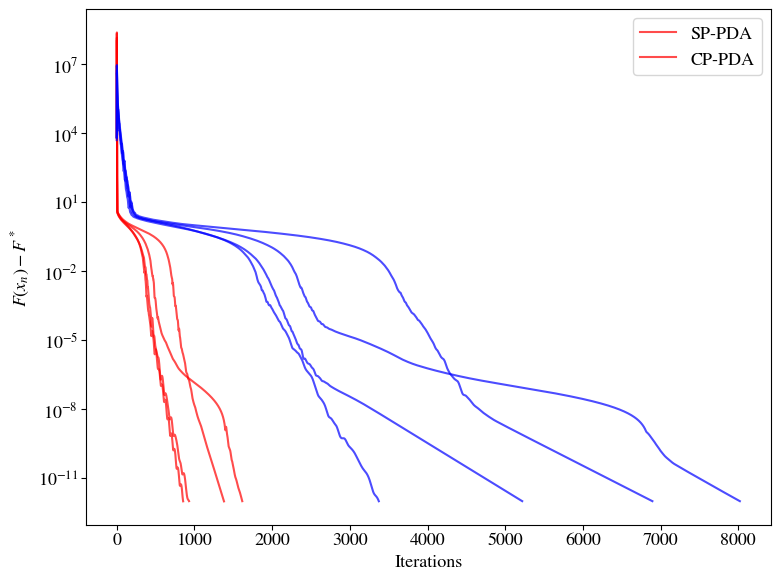

SP-PDA平均迭代次数: 1195.75
CP-PDA平均迭代次数: 5878.00
SP-PDA比CP-PDA快: 4.92倍


In [11]:
# 稳定性测试

def run_comparison_and_store(seed_list, max_iter=300000):
    # 声明使用全局变量
    global A, b, la
    
    # 存储结果的字典
    results = {
        'SP-PDA': [],
        'CP-PDA': []
    }
    
    for gen in seed_list:
        # 设置随机种子和正确的维度
        n = 500  # 特征维度
        m = 100  # 样本数量
        s = 10   # 稀疏度参数

        la = 0.1
        np.random.seed(gen)
        B = np.random.normal(0, 1, (m,n))
        p = 0.6
        A = np.zeros((m,n))
        A[0,:] = p*B[0,:]/(np.exp(1-p))
        for i in np.arange(1,m):
            A[i,:] = p*A[i-1,:] + B[i,:]
        
        np.random.seed(gen)
        w = np.random.uniform(-5, 5, n)
        w[s:] = 0
        np.random.seed(gen)
        w = np.random.permutation(w)
    
        np.random.seed(gen)
        nu = np.random.normal(0, 0.1, m)
        b = A.dot(w) + nu

        L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))
        x0 = np.zeros(n)
        y0 = -b
        
        # 定义容差和最大迭代次数
        T_pd = 1e-8
        N = max_iter
        
        # 首先运行一次SP-PDA获取最优值
        kk = 5
        ratio = 6
        tau = kk / L
        sigma = ratio * kk / L
        ans_init = pd_sp_all(J, prox_g, prox_f_conj, dis_sub, A, x0, y0, sigma, tau, 0, la, b, numb_iter=N, tol=T_pd)
        
        # 计算最优值
        t = A.dot(ans_init[1])-b
        min_val = 0.5* t.dot(t) + la* LA.norm(ans_init[1],1)
        
        # 设置更严格的容差
        T = 1e-12
        
        # SP-PDA
        ans_sp = pd_sp(J, prox_g, prox_f_conj, A, x0, y0, sigma, tau, min_val, numb_iter=max_iter, tol=T)
        
        # CP-PDA
        tau = 1. / L      
        sigma = 0.8 * 1./L  
        ans_cp = pd_new(J, prox_g, prox_f_conj, A, x0, y0, sigma, tau, min_val, numb_iter=max_iter, tol=T)
        
        # 存储结果
        results['SP-PDA'].append({
            'seed': gen,
            'iterations': len(ans_sp[0]),
            'errors': ans_sp[0]
        })
        
        results['CP-PDA'].append({
            'seed': gen,
            'iterations': len(ans_cp[0]),
            'errors': ans_cp[0]
        })
    
    return results

def plot_comparison_results(results):
    plt.figure(figsize=(8, 6))
    
    # 绘制SP-PDA结果
    for result in results['SP-PDA']:
        plt.semilogy(result['errors'], 'r-', alpha=0.7)
    
    # 绘制CP-PDA结果
    for result in results['CP-PDA']:
        plt.semilogy(result['errors'], 'b-', alpha=0.7)

    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('$F(x_n)-F^*$')
    plt.legend(['SP-PDA', 'CP-PDA'])
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig('figures/comparison_seeds.pdf')
    plt.show()
    
    # 打印每种方法的平均迭代次数
    sp_avg_iter = sum(r['iterations'] for r in results['SP-PDA']) / len(results['SP-PDA'])
    cp_avg_iter = sum(r['iterations'] for r in results['CP-PDA']) / len(results['CP-PDA'])
    
    print(f"SP-PDA平均迭代次数: {sp_avg_iter:.2f}")
    print(f"CP-PDA平均迭代次数: {cp_avg_iter:.2f}")
    print(f"SP-PDA比CP-PDA快: {cp_avg_iter/sp_avg_iter:.2f}倍")

# 使用不同的随机种子运行对比实验
seed_list = [1, 3, 4, 5]  # 可以根据需要调整种子数量
results = run_comparison_and_store(seed_list)
plot_comparison_results(results)